In [1]:
import numpy as np

In [2]:
# 0 = invalid, 1 = valid track, 2 = start, 3 = finish
track_1 = np.zeros((32, 17), dtype=np.int8)

# Mark valid regions
track_1[0:3, 3:9] = 1
track_1[3:10, 2:9] = 1
track_1[10:18, 1:9] = 1
track_1[18:25, 0:9] = 1
track_1[25, 0:10] = 1
track_1[26:28, 0:17] = 1
track_1[28, 1:17] = 1
track_1[29:31, 2:17] = 1
track_1[31, 3:17] = 1

# Mark starting line (overwrites valid)
track_1[0, 3:9] = 2

# Mark finish line (overwrites valid)
track_1[26:32, 16] = 3

velocity = np.array([0, 0])  # [v_horizontal, v_vertical]

actions = np.array([
    [-1, -1], [-1, 0], [-1, 1],
    [ 0, -1], [ 0, 0], [ 0, 1],
    [ 1, -1], [ 1, 0], [ 1, 1]
])

def get_random_starting_state_track_1():
    starting_location = np.array([0, np.random.randint(3, 10)])
    starting_velocity = np.array([0, 0])
    return np.concatenate((starting_location, starting_velocity), axis=0)

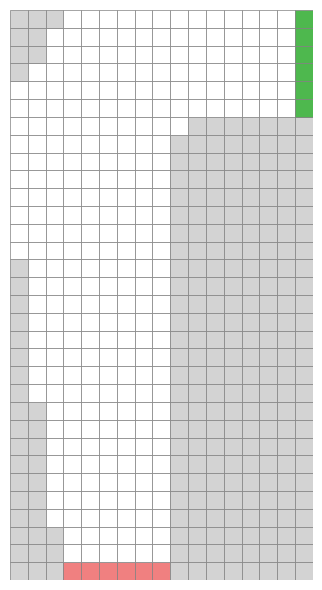

In [3]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

def visualize_track(track):
    rows, cols = track.shape
    
    fig, ax = plt.subplots(figsize=(4, 6))
    
    colors = {
        0: 'lightgray',   # invalid
        1: 'white',       # valid track
        2: '#f08080',     # start (light red)
        3: "#4EB84E"      # finish (light green)
    }
    
    for row in range(rows):
        for col in range(cols):
            color = colors[track[row, col]]
            rect = patches.Rectangle((col, row), 1, 1, 
                                      linewidth=0.5, 
                                      edgecolor='gray', 
                                      facecolor=color)
            ax.add_patch(rect)
    
    ax.set_xlim(0, cols)
    ax.set_ylim(0, rows)
    ax.set_aspect('equal')
    ax.axis('off')
    
    plt.tight_layout()
    plt.show()

visualize_track(track_1)

In [4]:
def get_valid_action_indices(velocity):
    """
    Before choosing an action, exclude any action that would result in (0, 0) velocity
    """
    valid = []
    for i, action in enumerate(actions):
        new_vel = np.clip(velocity + action, 0, 4)
        if not (new_vel[0] == 0 and new_vel[1] == 0):
            valid.append(i)
    return valid

In [5]:
def bresenham_supercover(x0, y0, x1, y1):
    cells = []
    dx = abs(x1 - x0)
    dy = abs(y1 - y0)
    x, y = x0, y0
    sx = 1 if x1 > x0 else -1
    sy = 1 if y1 > y0 else -1
    
    cells.append((x, y))
    
    if dx >= dy:
        err = 2 * dy - dx
        for _ in range(dx):
            if err >= 0:
                # diagonal step - add intermediate cells first
                cells.append((x+sx, y))
                cells.append((x, y+sy))
                y += sy
                err -= 2 * dx
            x += sx
            err += 2 * dy
            cells.append((x, y))
    else:
        err = 2 * dx - dy
        for _ in range(dy):
            if err >= 0:
                # diagonal step - add intermediate cells first
                cells.append((x, y+sy))
                cells.append((x+sx, y))
                x += sx
                err -= 2 * dy
            y += sy
            err += 2 * dx
            cells.append((x, y))
    
    return cells

In [6]:
def is_finish(cell, track):
    x, y = cell
    rows, cols = track.shape
    if x < 0 or x >= cols or y < 0 or y >= rows:
        return False
    return track[y, x] == 3

def is_invalid(cell, track):
    x, y = cell
    rows, cols = track.shape
    if x < 0 or x >= cols or y < 0 or y >= rows:
        return True
    return track[y, x] == 0

def check_path(x0, y0, x1, y1, track):
    cells = bresenham_supercover(x0, y0, x1, y1)
    for cell in cells:
        if is_finish(cell, track):
            return "finish", np.array([cell[1], cell[0]])
        elif is_invalid(cell, track):
            return "crash", np.array([cell[1], cell[0]])
    return "valid", np.array([y1, x1])

In [7]:
# Algorithm parameter: small ε > 0
epsilon = 0.1

In [8]:
# Initialize

# NOTE: State is position and velocity.
# There are 32x17 grid positions and 5 velocity for each of the horizontal and vertical component i.e. 5x5
# Total: 32 x 17 x 5 x 5

# π an arbitrary ε-soft policy
policy = np.zeros((32, 17, 5, 5, 9), dtype=np.float32)

for vy in range(5):
    for vx in range(5):
        valid = get_valid_action_indices(np.array([vy, vx]))
        prob = 1.0 / len(valid)
        for a in valid:
            policy[:, :, vy, vx, a] = prob

In [9]:
# Q(s, a) ∈ R (arbitrarily), for all s ∈ S, a ∈ A(s)
action_value = np.zeros((32, 17, 5, 5, 9), dtype=np.float32)

In [10]:
# N(s, a) = 0, for all s ∈ S, a ∈ A(s)
num_iterations_till_first_visit = np.zeros((32, 17, 5, 5, 9), dtype=np.uint64)

In [11]:
def run_episode(track, policy, noise=True):
    # set current state on a random starting point
    state = get_random_starting_state_track_1()
    
    episode = []
    terminate_episode = False
    n_steps = 10_000

    while(True):
        reward = -1

        # sample from the distribution of ε-soft actions
        action_index_per_policy = np.random.choice(9, p=policy[tuple(state)])

        if noise and np.random.random() <= 0.1:
            action_index_to_apply = 4 #[0, 0]
        else:
            action_index_to_apply = action_index_per_policy
        
        current_location = state[:2]
        current_velocity = state[2:]
        action = actions[action_index_to_apply]
        projected_velocity = np.clip(current_velocity + action, 0, 4)
        projected_location = current_location + projected_velocity

        projected_traversal = check_path(
            current_location[1], 
            current_location[0], 
            projected_location[1], 
            projected_location[0],
            track)

        projected_location_status, projected_location = projected_traversal
    
        match projected_location_status:
            case "finish":
                terminate_episode = True
                reward = 0
                episode.append((state, action_index_per_policy, reward, projected_location))
            case "crash":
                episode.append((state, action_index_per_policy, reward, projected_location))
                state = get_random_starting_state_track_1()
            case _:
                episode.append((state, action_index_per_policy, reward, projected_location))
                state = np.concatenate((projected_location, projected_velocity), axis=0)

        if terminate_episode:
            break

    return episode

In [12]:
#episode = run_episode(track_1, policy)

#for i, (state, action_idx, reward, projected_location) in enumerate(episode):
#    print(f"Step {i}: state={state}, action={actions[action_idx]}, reward={reward}, projected_location={projected_location}")

In [13]:
def is_first_visit(episode, t, S_t, A_t):
    for i in range(t):
        S_i, A_i, _, _ = episode[i]
        if (S_t == S_i).all() and A_t == A_i:
            return False
    return True

In [ ]:
def optimal_policy_estimation(num_episodes):
    for _ in range(num_episodes):
        episode = run_episode(track_1, policy)
        G = 0
        gamma = 1
        
        for t in range(len(episode) - 1, -1, -1):
            S_t, A_t, R_t, _ = episode[t]
            G = gamma * G + R_t

            # Check if (S_t, A_t) appears in episode[:t]
            if is_first_visit(episode, t, S_t, A_t):

                # If first visit, update Q and policy
                state_actionindex = np.concatenate((S_t, [A_t]), axis=0)
                t_state_actionindex = tuple(state_actionindex)

                # increment N(s, a)
                num_iterations_till_first_visit[t_state_actionindex] += 1

                # incremental update of action-values
                action_value[t_state_actionindex] += (1/num_iterations_till_first_visit[t_state_actionindex]) * (G - action_value[t_state_actionindex])

                Q_s = action_value[tuple(S_t)]
                valid_actions = get_valid_action_indices(S_t[2:])
                A_star = valid_actions[np.argmax(Q_s[valid_actions])]
                
                
                num_valid_actions = len(valid_actions)

                for a in valid_actions:
                    if a == A_star:
                        policy[tuple(S_t)][a] = 1 - epsilon + (epsilon/num_valid_actions)
                    else:
                        policy[tuple(S_t)][a] = epsilon/num_valid_actions
                        

In [19]:
import matplotlib.pyplot as plt
from IPython import display
import time

def visualize_episode(track, episode):
    rows, cols = track.shape
    cmap = plt.cm.colors.ListedColormap(['lightgray', 'white', '#f08080', '#90ee90'])
    
    fig, ax = plt.subplots(figsize=(4, 6))
    
    for t, (state, action_idx, reward, projected_location) in enumerate(episode):
        ax.clear()
        ax.imshow(track, origin='lower', cmap=cmap, vmin=0, vmax=3)
        
        # Draw grid lines
        ax.set_xticks(np.arange(-0.5, cols, 1), minor=True)
        ax.set_yticks(np.arange(-0.5, rows, 1), minor=True)
        ax.grid(which='minor', color='gray', linewidth=0.5)
        ax.tick_params(which='both', length=0)
        
        # Draw car position
        y, x = state[0], state[1]
        ax.plot(x, y, 'bo', markersize=8)
        
        # Draw projected position
        proj_y, proj_x = projected_location[0], projected_location[1]
        ax.plot(proj_x, proj_y, 'rx', markersize=8)
        
        ax.set_title(f'Step {t} | Velocity: ({state[2]}, {state[3]})')
        
        display.clear_output(wait=True)
        display.display(fig)
        time.sleep(0.05)
    
    plt.close()

In [16]:
num_episodes = 22
optimal_policy_estimation(num_episodes)

In [17]:
episode = run_episode(track_1, policy, noise=False)
print(len(episode))

239


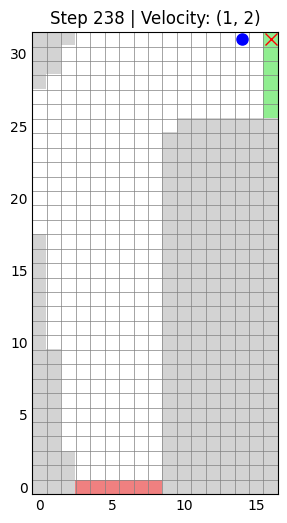

In [20]:
visualize_episode(track_1, episode)